# __Online Shoppers Purchasing Intention:__
# __A classification problem__

Due to the change in customer consumption habits, a retail company it is promoting the online sales service. The company wants to make a machine learning model to classify customers based on the probability of generating income when shopping on the web.

**The goal is to perform a series of specific actions for customers who are most likely to make purchases on the web**

To do this, the company has been collecting data with its Google Analytics tool. The dataset has session data, each of them from a different client in a period of one year and their activities.

The data for this problem comes from the University of California Irvine. More details at the following url: https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset#

=> We will need the file <code>online_shoppers_intention.csv</code>

## __Dataset Characteristics:__

The dataset provided has a total of 12 330 rows with 18 columns. Among these columns, 9 are numeric and 9 are categorical, including the target feature "Revenue".

The categorical features are: Special Day, Month, Operating Systems, Browser, Region, Traffic Type, Visitor Type, Weekend. The numerical characteristics are: Administrative, Administrative Duration, Informational, Information Duration, Product Related, Product Relationship Duration, Bounce Rates, Exit Rates, Page Values.

* I. The values of the following features are derived from the **URL information of the pages** visited by the user and updated in real time when a user takes an action, e.g. moving from one page to another:

**Administrative**: Number of pages visited by the user for activities related to the management of the user account.

**Administrative_Duration**: Time the user spends on the administrative pages.

**Informational**: Number of pages visited by the user on the website.

**Informational_Duration**: Time the user spends on the informative pages.

**ProductRelated**: Number of pages related to the product visited by the user.

**ProductRelated_Duration**: Time the user spends on product-related pages.

* II. The "Bounce Rate", "Exit Rate" and "Page Value" features represent the **metrics measured by "Google Analytics"** for each page in the e-commerce site:

**BounceRates**: The value of "Bounce Rate" feature for a web page refers to the percentage of visitors who enter the site from that page and then leave ("bounce") without triggering any other requests to the analytics server during that session. 

**ExitRates**: The value of "Exit Rate" feature for a specific web page is calculated as for all pageviews to the page, the percentage that were the last in the session (the percentage of people who left your site from that page).

**PageValues**: The "Page Value" feature represents the average value for a web page that a user visited before completing an e-commerce transaction.
This value is intended to give an idea of which page on a site has contributed the most to the same site's revenue. If the page was not involved in an e-commerce transaction for the website in any way, then the page value for that page will be 0, since the page was never viewed in a session where a transaction occurred.

* III. __Other information:__

**SpecialDay**: Indicates the proximity of the visiting day to a special event such as Mother's Day or festivals such as Christmas, in which the sessions are more likely to be finalized with transaction. A nonzero value indicates that the event is far and zero before and after this date unless it is close to another special day. 

**Month**: Month of the year.

**OperatingSystems**: Visitor's operating system.

**Browser**: Visitor's browser.

**Region**: Geographical region from which the visitor started the session.

**TrafficType**: Source of traffic through which the user has entered the web.

**VisitorType**: Defines the nature of the user, as returning or new visitor.

**Weekend**: Boolean value indicating whether the date of the visit is weekend (Boolean value).

**Revenue**: Labeled as a **class or target**, it indicates if they can get income or not (Boolean).


* NOTE: It should be noted that the original source in UCI does not provide with metadata that explains what the numbers of the variables mean: Region, TrafficType, OperatingSystems and Browser. Therefore we cannot transform these values into understandable values.

## Importing libraries

In [1]:
# Data preprocessing
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Statistic packages/functions
from scipy.stats import probplot, norm, shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import LabelEncoder, StandardScaler 

# Machine learning model & experiments
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Metrics Libraries
from sklearn import metrics
from sklearn.metrics import classification_report #####
from sklearn.model_selection import cross_val_score ####
from sklearn.metrics import accuracy_score, confusion_matrix

# Other settings
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None # to display all columns
from IPython.core.display import display, HTML 

## Defining functions

In [2]:
def describe_features(df, col):
    '''
    Function that describes the columns including their count of values,
    unique number of values and most frequent values
    '''
    print(f'Column: {col}')
    print(f'Count values: {df[col].count()}  -  Number of unique values: {df[col].nunique()}')
    print('Most frequent values:')
    for i, v in df[col].value_counts().iloc[:10].items() :
        print(i, '\t', v)
    print('\n')
        

def features_vs_target(X, Y, return_type='axes'):
    '''
    Represents scatter plots of the feature variables X
    with the target variable Y
    '''
    fig_tot = (len(X.columns))
    fig_row = 4.
    size_fig = 4.    
    num_rows = int( np.ceil(fig_tot/fig_row) )    
    plt.figure( figsize=( fig_row*size_fig+5, fig_row*size_fig+5 ) )
    c = 0 
    for i, col in enumerate(X.columns):
        plt.subplot(num_rows, fig_row, i+1)
        sns.scatterplot(x=X[col], y=Y)
        plt.title( '%s vs %s' % (col, 'target') )
        plt.ylabel('Target')
        plt.xlabel(col)
        plt.xticks([])
    plt.show()

def double_hist(x_1, x_0, n_bins=11, title='', label_1='Class 1', 
                          label_0='Class 0', density=0):
    '''
    Function that receives two probability distributions and represents them
    on the same chart
    '''
    bins = n_bins
    #to get the histogram of class 1 >50k and class 0 <=50k
    plt.hist(x_1, bins, density = density, alpha=0.5, label=label_1, color='red')    
    plt.hist(x_0, bins, density = density, alpha=0.5, label=label_0, color='green')
    plt.title(title)
    plt.legend(loc='best') 

def hist_pos_neg_feat(x, y, density=0, nbins=11, targets=(0,1)):
    '''
    Represents the variables in x divided into two distributions
    according to its value of y is 1 or 0
    '''
    fig_tot = len(x.columns)
    fig_row = 4.; size_fig = 4.
    num_rows = int( np.ceil(fig_tot/fig_row) )
    plt.figure( figsize=( fig_row*size_fig+2, num_rows*size_fig+2 ) )
    
    target_neg, target_pos = targets
    for i, feat in enumerate(x.columns):
        plt.subplot(num_rows, fig_row, i+1);
        plt.title('%s' % feat)
        idx_pos = y == target_pos
        idx_neg= y == target_neg
        double_hist(x[feat][idx_pos].values, x[feat][idx_neg].values, nbins, 
                   density = density, title=('%s' % feat))
   
def shapiro_test_normality(df, return_type='axes', title='Normality check of the distribution'):
    '''
    Represent by means of Q-Q Plots the shapiro test to verify the
    normality of the distribution of the variables
    '''
    fig_tot = (len(df.columns))
    fig_row = 3.
    size_fig = 4.
    num_rows = int( np.ceil(fig_tot/fig_row) )    
    plt.figure( figsize=( fig_row*size_fig+5, num_rows*size_fig+2 ) )
    c = 0 
    shapiro_test = {}
    lambdas = {}
    for i, col in enumerate(df.columns):
        ax = plt.subplot(num_rows, fig_row, i+1)
        probplot(x = df[df.columns[i]], dist=norm, plot=ax)
        plt.title(df.columns[i])
        shapiro_test[df.columns[i]] = shapiro(df[df.columns[i]])
        plt.xticks([])
    plt.suptitle(title)
    plt.show()
    shapiro_test = pd.DataFrame(shapiro_test, index=['Test Statistic', 'p-value']).transpose()
    return shapiro_test


def label_values(ax, spacing=5):
    '''
    Function to label the count and % at the top of each bar graph
    '''
    total = 0
    for rect in ax.patches:
        total += rect.get_height()

    for rect in ax.patches:
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        space = spacing
        
        va = 'bottom'
        
        if y_value < 0:
            space *= -1
            va = 'top'
        label = "{:.2f}, {:.2f}%".format(y_value, y_value/total*100)
        ax.annotate(
            label,                      
            (x_value, y_value),         
            xytext=(0, space),          
            textcoords="offset points", 
            ha='center',                
            va=va)
        
def highlight_max(s):
    '''
    Function for colouring negative values red and positive values in blue
    '''
    if s.dtype == np.object:
        is_neg = [False for _ in range(s.shape[0])]
    else:
        is_neg = s < 0
    return ['color: red;' if cell else 'color:blue' 
            for cell in is_neg]

## Importing the dataset

In [3]:
XY = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00468/online_shoppers_intention.csv', sep=',', index_col=False)

In [4]:
print(u'- Rows in the dataset: {}'.format(XY.shape[0]))
print(u'- Columns in the dataset: {}'.format(XY.shape[1]))
print(u'- Variable names: {}'.format(list(XY.columns)))
XY[:2]

- Rows in the dataset: 12330
- Columns in the dataset: 18
- Variable names: ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType', 'Weekend', 'Revenue']


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.0,0.2,0.2,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.0,0.0,0.1,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False


## Data processing (I) - Treatment of missing values and categorical variables

In [5]:
XY.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

* Defining numerical and categorical variables:

In [6]:
num_features = ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 
                'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay']

cat_features = ['Month' ,'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType', 'Weekend', 'Revenue'] # target value included

### I. Missing data
We check if there is any missing values in the dataset. If they exist, we have to decide if they must be replaced (options here are the fillna function or the MissForest library) or if we can delete them (using the dropna function).

In [7]:
print("\033[1m Number of missing values: \033[0m \n", XY.isnull().sum())
print("\n\033[1m % of missing values: \033[0m \n", XY.isnull().sum()/len(XY)*100)

 Number of missing values:  
 Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

 % of missing values:  
 Administrative             0.0
Administrative_Duration    0.0
Informational              0.0
Informational_Duration     0.0
ProductRelated             0.0
ProductRelated_Duration    0.0
BounceRates                0.0
ExitRates                  0.0
PageValues                 0.0
SpecialDay                 0.0
Month                      0.0
OperatingSystems           0.0
Browser                    0.0
Region

* __Note:__

The first eight columns have missing values that represent 0.11% of the total observations in the dataset. Removing such a small proportion (such as 14 observations out of a total of 12,330 observations) would not cause a significant change in the dataset.

For this reason, it has been decided to opt for the simplest method and simply **eliminate** all the missing values in the dataset. For this we will apply the *dropna()* method below:

In [8]:
print('Number of rows before (including missing values): ',XY.shape[0])
XY = XY.dropna()
print('Number of rows after deleting missing values: ',XY.shape[0])

Number of rows before (including missing values):  12330
Number of rows after deleting missing values:  12330


### II. Treatment of categorical variables (1st part)

Before analyzing and visualizing the variables and feature and their correlations, we will have a look at the non numerical data types (as seen in the .info summary above). Therefore, we will apply firstly some transformations. Let's have a look at it:

In [9]:
XY[:2]

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.0,0.2,0.2,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.0,0.0,0.1,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False


In [10]:
XY.describe(exclude='number')

,Month,VisitorType,Weekend,Revenue
count,12330,12330,12330,12330
unique,10,3,2,2
top,May,Returning_Visitor,False,False
freq,3364,10551,9462,10422


In [11]:
# "Weekend" and "Revenue" are boolean data types, 
# having as value True or False if condition is meet
for i in ["Weekend","Revenue"]:
    print(i,"data type: ", XY[i].dtype)

Weekend data type:  bool
Revenue data type:  bool


In [12]:
# Analyzing the three unique values of the visitor type variable
print(XY.VisitorType.value_counts())

# And checking which months does the dataset contain (10)
print('\n', XY.Month.value_counts())

Returning_Visitor    10551
New_Visitor           1694
Other                   85
Name: VisitorType, dtype: int64

 May     3364
Nov     2998
Mar     1907
Dec     1727
Oct      549
Sep      448
Aug      433
Jul      432
June     288
Feb      184
Name: Month, dtype: int64


* **Justification of the 1st transformation:**

1. The __Weekend and Revenue__ columns are of the Boolean data types, therefore we will transform them into numbers by applying a label encoder where 0 will be the "False" and 1 will be the "True"
2. The __VisitorType__ column has three categories, "Other", "New_Visitor" and "Returning_Visitor". Since we want to know whether the customer is a returning visitor or a new one, we will pass it down to just two categories: Returning_Visitor and New_Visitor. Here we will perform the substitution with the loc function, that takes the "New_Visitor" and "Other" as 0 and "Returning_Visitors" as 1
3. The __Month__ column contains 10 months of the year, we will transform them into numerical values using the replace method with the help of a dictionary

In [13]:
le = LabelEncoder()

# Transforming the Boolean columns Weekend and Revenue using a label encoder:
XY.Weekend= le.fit_transform(XY.Weekend.values)
XY.Revenue= le.fit_transform(XY.Revenue.values)

# Transforming the VisitorType column via a loop:
XY.loc[XY['VisitorType'] == 'Returning_Visitor', 'VisitorType'] = 1
XY.loc[XY['VisitorType'] == 'New_Visitor', 'VisitorType'] = 0
XY.loc[XY['VisitorType'] == 'Other', 'VisitorType'] = 0

XY['VisitorType'] = pd.to_numeric(XY.VisitorType)

# Transforming the Month column using the replace method with a specific range:
dic = {'Feb': 2, 'Mar':3,
       'May': 5, 'June': 6, 'Jul': 7, 'Aug': 8,
       'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
XY["Month"].replace(dic, inplace=True)

# Checking the changes in the dataset
XY[:2]

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.0,0.2,0.2,0.0,0.0,2,1,1,1,1,1,0,0
1,0,0.0,0,0.0,2,64.0,0.0,0.1,0.0,0.0,2,2,2,1,2,1,0,0


In [14]:
# checking the two categories of VisitorType
XY.VisitorType.value_counts()

1    10551
0     1779
Name: VisitorType, dtype: int64

There are no more non-numeric variables in the dataset:

In [15]:
XY.select_dtypes(exclude=['number']).columns

Index([], dtype='object')

In [16]:
# Analyzing categorical variables          
for col in cat_features:
    describe_features(XY,col)

Column: Month
Count values: 12330  -  Number of unique values: 10
Most frequent values:
5 	 3364
11 	 2998
3 	 1907
12 	 1727
10 	 549
9 	 448
8 	 433
7 	 432
6 	 288
2 	 184


Column: OperatingSystems
Count values: 12330  -  Number of unique values: 8
Most frequent values:
2 	 6601
1 	 2585
3 	 2555
4 	 478
8 	 79
6 	 19
7 	 7
5 	 6


Column: Browser
Count values: 12330  -  Number of unique values: 13
Most frequent values:
2 	 7961
1 	 2462
4 	 736
5 	 467
6 	 174
10 	 163
8 	 135
3 	 105
13 	 61
7 	 49


Column: Region
Count values: 12330  -  Number of unique values: 9
Most frequent values:
1 	 4780
3 	 2403
4 	 1182
2 	 1136
6 	 805
7 	 761
9 	 511
8 	 434
5 	 318


Column: TrafficType
Count values: 12330  -  Number of unique values: 20
Most frequent values:
2 	 3913
1 	 2451
3 	 2052
4 	 1069
13 	 738
10 	 450
6 	 444
8 	 343
5 	 260
11 	 247


Column: VisitorType
Count values: 12330  -  Number of unique values: 2
Most frequent values:
1 	 10551
0 	 1779


Column: Weekend
Count val

Now, let's have a look at the target variable. Remember that the variable "Revenue" indicates whether we will earn revenue from customers:

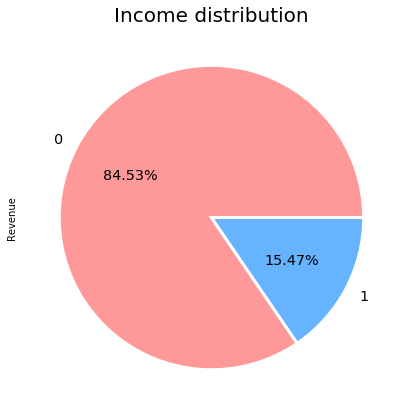

In [17]:
# adding colors
colors = ['#ff9999','#66b3ff']

XY['Revenue'].value_counts().plot(kind='pie', colors=colors, figsize=(7,7), autopct='%.2f%%', wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'}, textprops={'size': 'x-large'})
_ = plt.title('Income distribution', fontsize=20)

__NOTE:__

* As can be seen, the majority of the data is concentrated in the class 0 (84.51% against 15.49%). This means that the target variable is unbalanced. 

* It is important to mention that unbalanced datasets could cause a big problem: Models trained on unbalanced datasets often have poor results when they have to generalize (predict a class or classify unseen observations). Despite the algorithm you choose, some models will be more susceptible to unbalanced data than others. IT is then dangerous because the algorithm is then prone to overfitting the majority class. There are techniques to treat this problem such as resampling the dataset (undersampling, oversampling), VAE, SMOTE...

* However, for this case I don't consider this to be a highly unbalanced dataset, therefore I won't take further steps in this matter.

### Division features X + target Y

In [18]:
X = XY.drop('Revenue', axis=1)
Y = XY['Revenue']

## Visualization y correlations

### I. Descriptive Analysis

In [19]:
# Analyzing numerical variables
XY[num_features].describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.315166,80.818611,0.503569,34.472398,31.731468,1194.746220,0.022191,0.043073,5.889258,0.061427
std,3.321784,176.779107,1.270156,140.749294,44.475503,1913.669288,0.048488,0.048597,18.568437,0.198917
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,184.137500,0.000000,0.014286,0.000000,0.000000
50%,1.000000,7.500000,0.000000,0.000000,18.000000,598.936905,0.003112,0.025156,0.000000,0.000000
75%,4.000000,93.256250,0.000000,0.000000,38.000000,1464.157214,0.016813,0.050000,0.000000,0.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000


* __NOTE__:

We can see the presence of negative values in the columns __Administrative_Duration, Informational_Duration y ProductRelated_Duration__:

In [20]:
# Counting the number of rows that contain values -1 
# Note htat all columns in the dataset return the same count value,
# therefore we have choosen one col (Revenue) to show only one value

negatives = ["Administrative_Duration", "Informational_Duration", "ProductRelated_Duration"]

for col in negatives:
   print(XY[XY[col] == -1].groupby([col])['Revenue'].count())

Series([], Name: Revenue, dtype: int64)
Series([], Name: Revenue, dtype: int64)
Series([], Name: Revenue, dtype: int64)


In [21]:
for col in negatives:
    print(col,' Representation of the values with -1 in the dataset:', round(XY[XY[col] == -1]['Revenue'].count()/len(XY[col])*100, 2), '%')

Administrative_Duration  Representation of the values with -1 in the dataset: 0.0 %
Informational_Duration  Representation of the values with -1 in the dataset: 0.0 %
ProductRelated_Duration  Representation of the values with -1 in the dataset: 0.0 %


* Since the documentation does not explain what these negative values mean, we don't know for sure the best method to deal with them. As they represent a small portion of the data, we could either delete them or replace the values. We will assume that the negative values are an error and replace it with the value 0 (equal to 0 minutes duration):

In [22]:
for col in negatives:
    XY.loc[XY[col] == -1, col] = 0
    XY[col] = pd.to_numeric(XY[col])

### II. Visualizing the variable:

### Boxplots

* We will visualize boxplots of the numerical variables. To see the representation of the data better in the graphic, we will scale the values to make them comparable in the visual -> **Remember that standarization rescales the data to have a mean of 0 and a standard deviation of 1**

In [23]:
# preview of the dataset before changes:
X_scaler = X.copy()
X_scaler[:2]

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend
0,0,0.0,0,0.0,1,0.0,0.2,0.2,0.0,0.0,2,1,1,1,1,1,0
1,0,0.0,0,0.0,2,64.0,0.0,0.1,0.0,0.0,2,2,2,1,2,1,0


In [24]:
# Standarizing only numerical features with the function StandardScaler
scaler = StandardScaler()

X_scaler[num_features] = scaler.fit_transform(X_scaler[num_features])

X_scaler[:2]

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend
0,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348,3.667189,3.229316,-0.317178,-0.308821,2,1,1,1,1,1,0
1,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.590903,-0.457683,1.171473,-0.317178,-0.308821,2,2,2,1,2,1,0


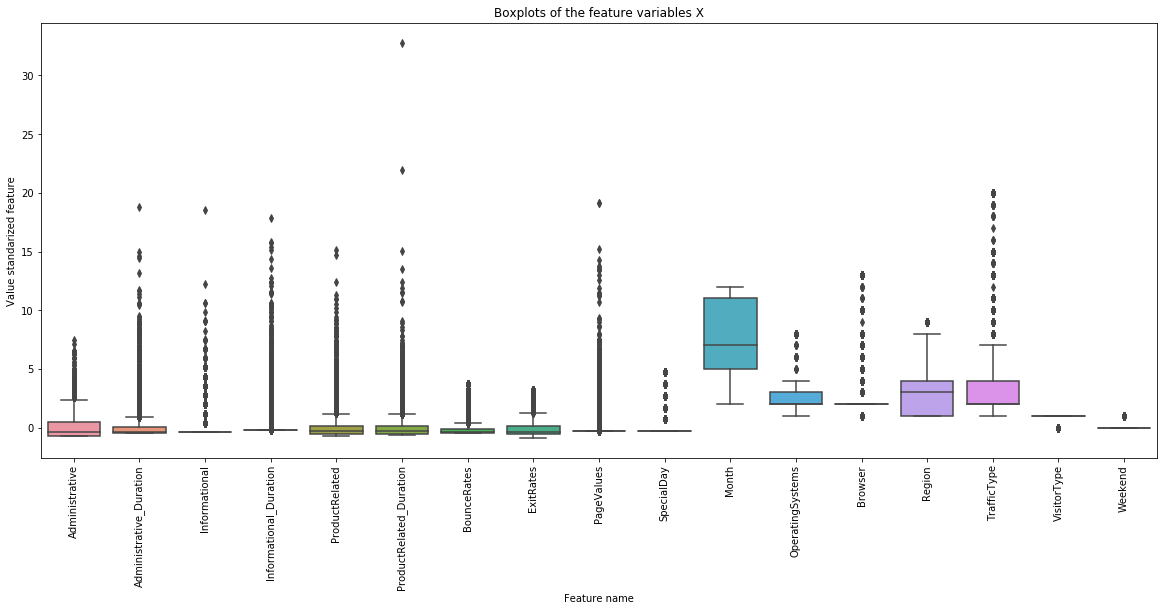

In [25]:
# Visualizing features with Boxplots

plt.figure(figsize=(20,8))
ax = sns.boxplot(data=X_scaler)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title(u'Boxplots of the feature variables X')
plt.ylabel('Value standarized feature')
_ = plt.xlabel('Feature name')

__NOTE:__

* As seen before in the boxplots, most of the features have many outliers or extreme values. We will deal with these later.

### Bar Plots

 Categorical variable bar chart Month


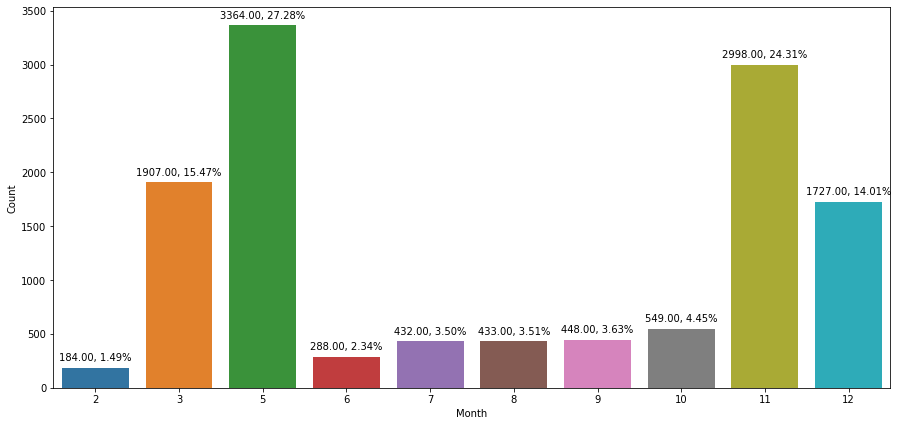

 Categorical variable bar chart OperatingSystems


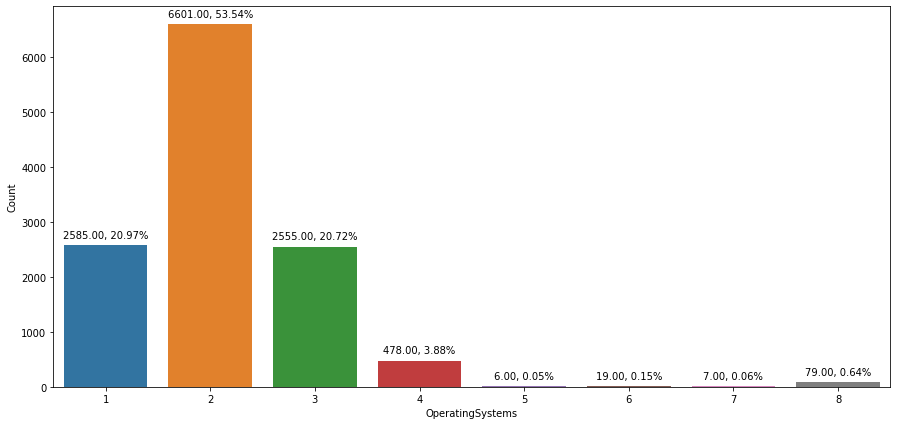

 Categorical variable bar chart Browser


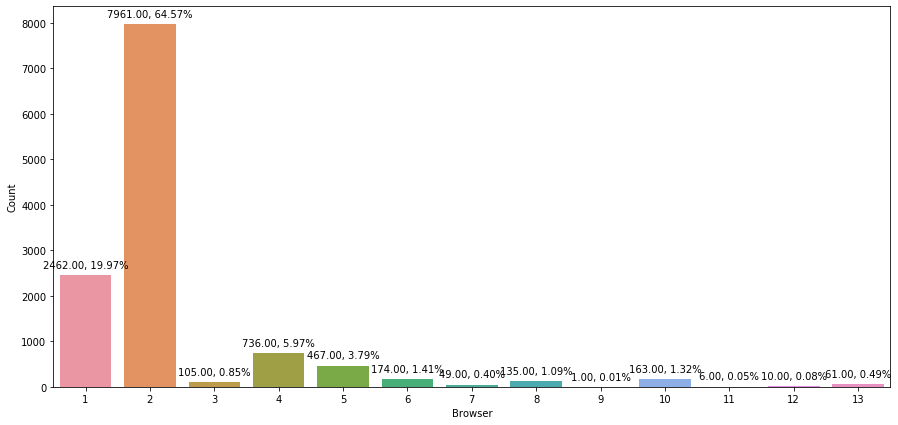

 Categorical variable bar chart Region


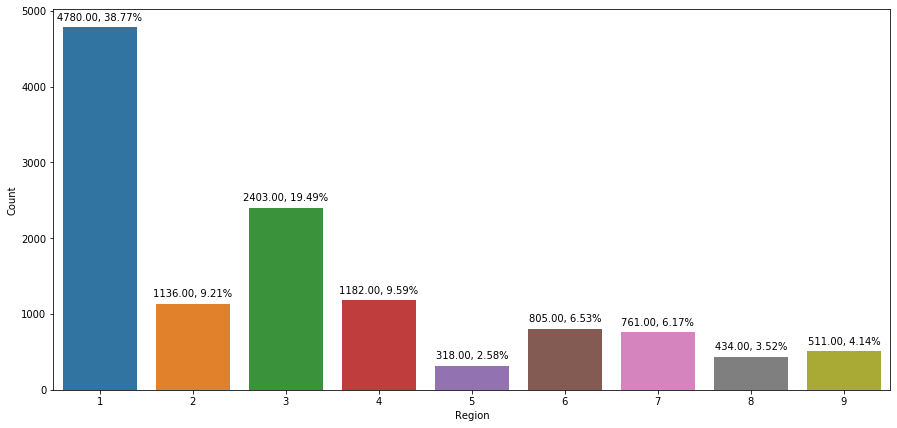

 Categorical variable bar chart TrafficType


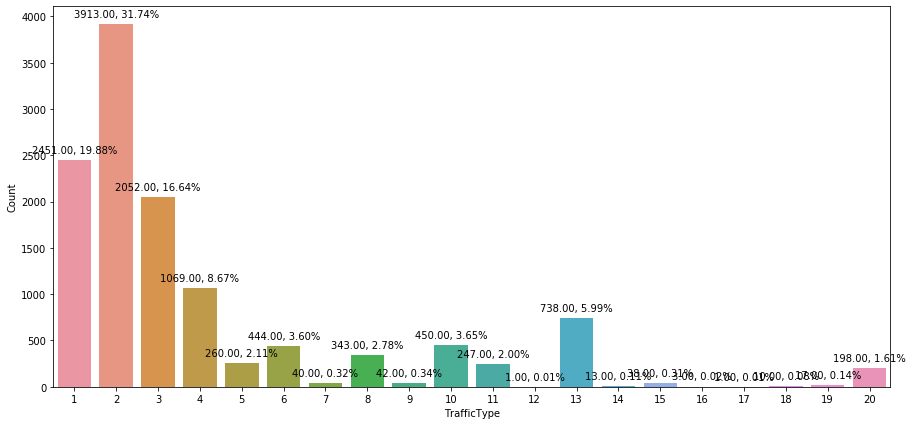

 Categorical variable bar chart VisitorType


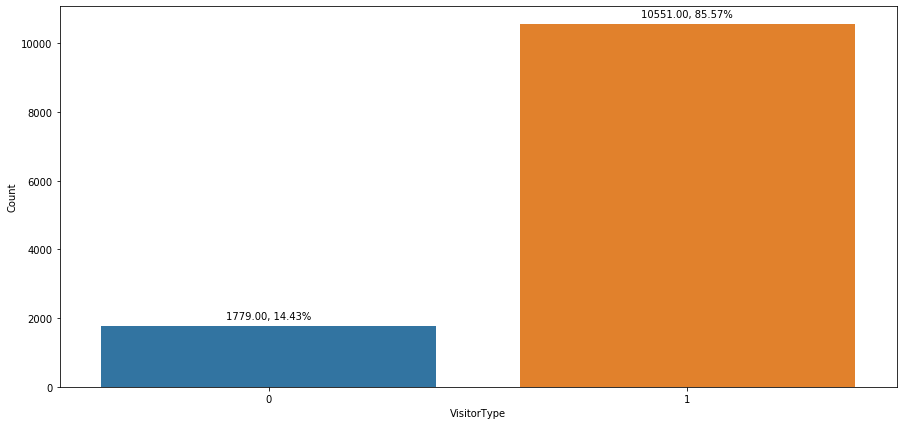

 Categorical variable bar chart Weekend


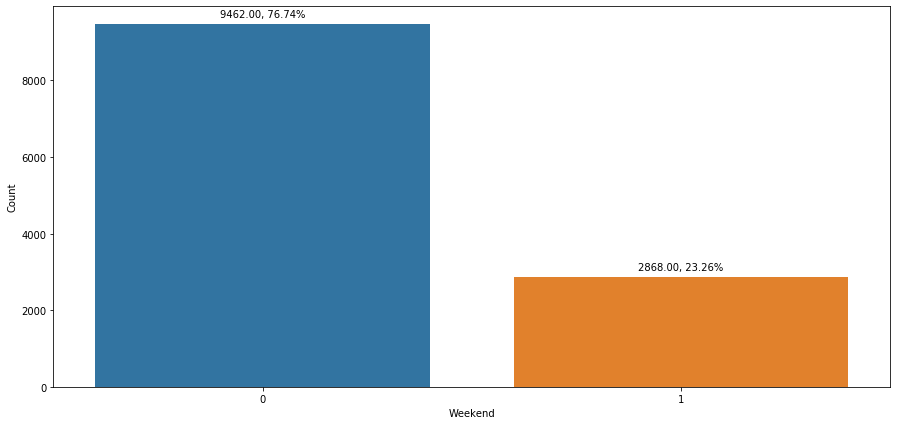

 Categorical variable bar chart Revenue


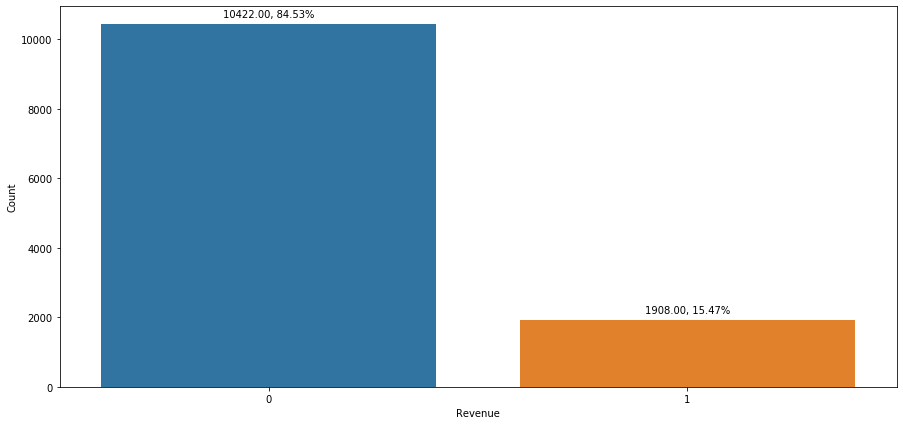

In [26]:
# Visualizamos la distribucion de las variables categoricas
for col in cat_features:
    plt.figure(figsize=(15,7))
    print("\033[1m Categorical variable bar chart {}".format(col))
    ax = sns.countplot(x=XY[col], data=XY)

    plt.ylabel('Count')
    label_values(ax)
    plt.show()

### Histogramas

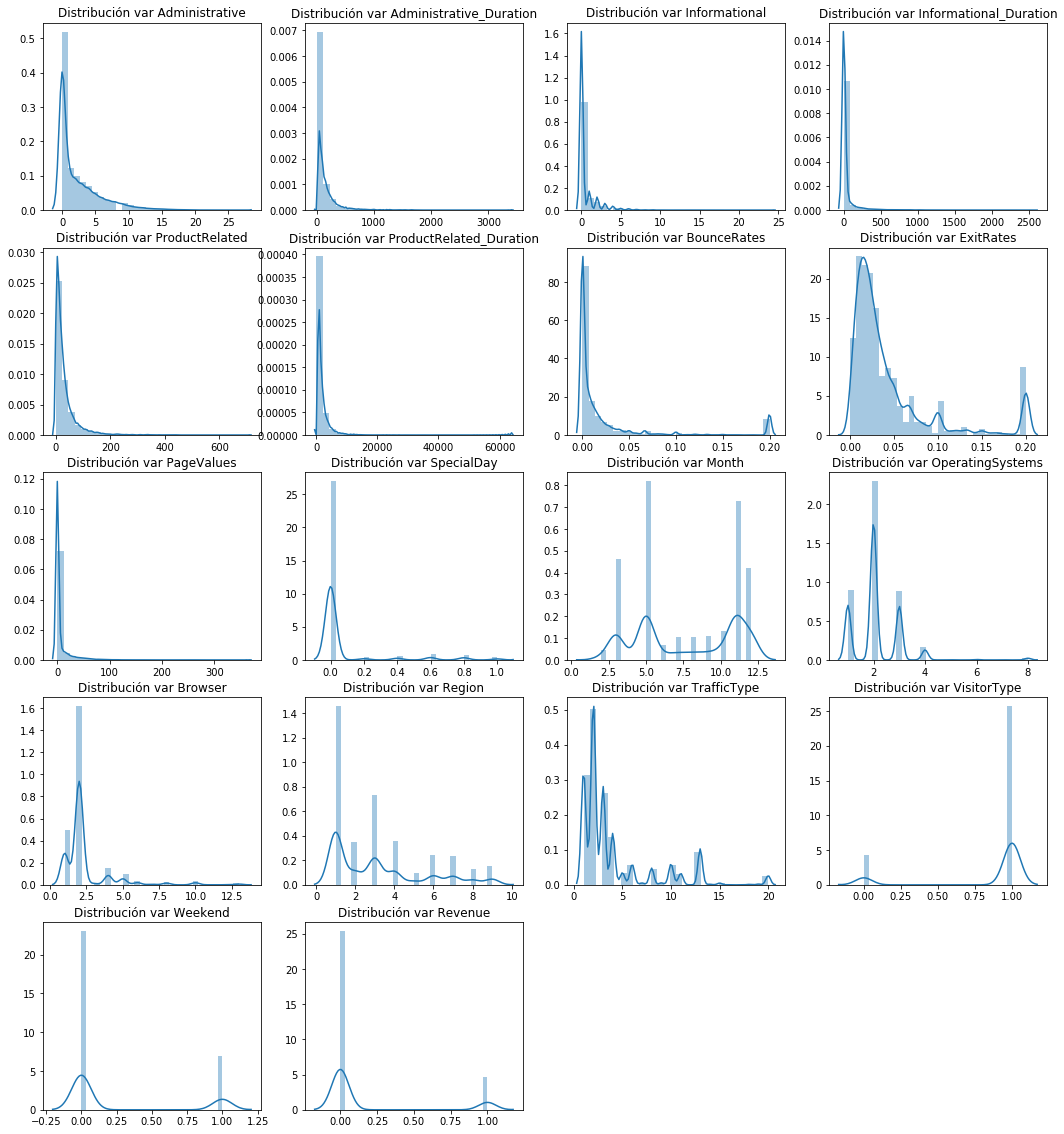

In [27]:
plt.figure(figsize=(18,20))
n = 0
for i, column in enumerate(XY.columns):
    n+=1
    plt.subplot(5, 4, n)
    sns.distplot(XY[column], bins=30)
    plt.title('Distribución var {}'.format(column))
    plt.xlabel(None)
plt.show()

* **Observations of the Analysis per variable:**

1. __'Administrative' & 'Administrative_Duration'__: Most users did not visit pages related to user account management activities and do not spend much time on administrative web pages.
2. __'Informational' & 'Informational_Duration'__: Most users did not spend much time on informational web pages, however there are users who visit multiple informational web pages. It would be interesting to know what exactly informative pages are, is it just the "about" of the web page or it is also include search engines like Google?
3. __'ProductRelated' & 'ProductRelated_Duration'__: As can be seen in the previous visuals, there are a large number of users who visit multiple web pages related to the product, in the same way the duration of time is greater for related web pages with the products.
4. __'SpecialDay'__: The proximity of the visit day to a special event seems to be present as the day of the special event approaches
5. __'Month'__: The busiest months are May, November, March and December
6. __'Region'__: The regions with the most users in the dataset are regions 1, 3 and 4
7. __'Operating_systems':__ of all operating systems, 4 predominate (probably the market leaders: windows, macOS/iOS, android, linux)
8. __'Browser':__ of browsers there are two leading (probably Google and Safari)

### III. Analysis of two variables:

### Relation features vs target

These graphs are interesting to analyze the predictive power of the variables. The more the two distributions are separated, the better to predict since it is easier to discriminate them:

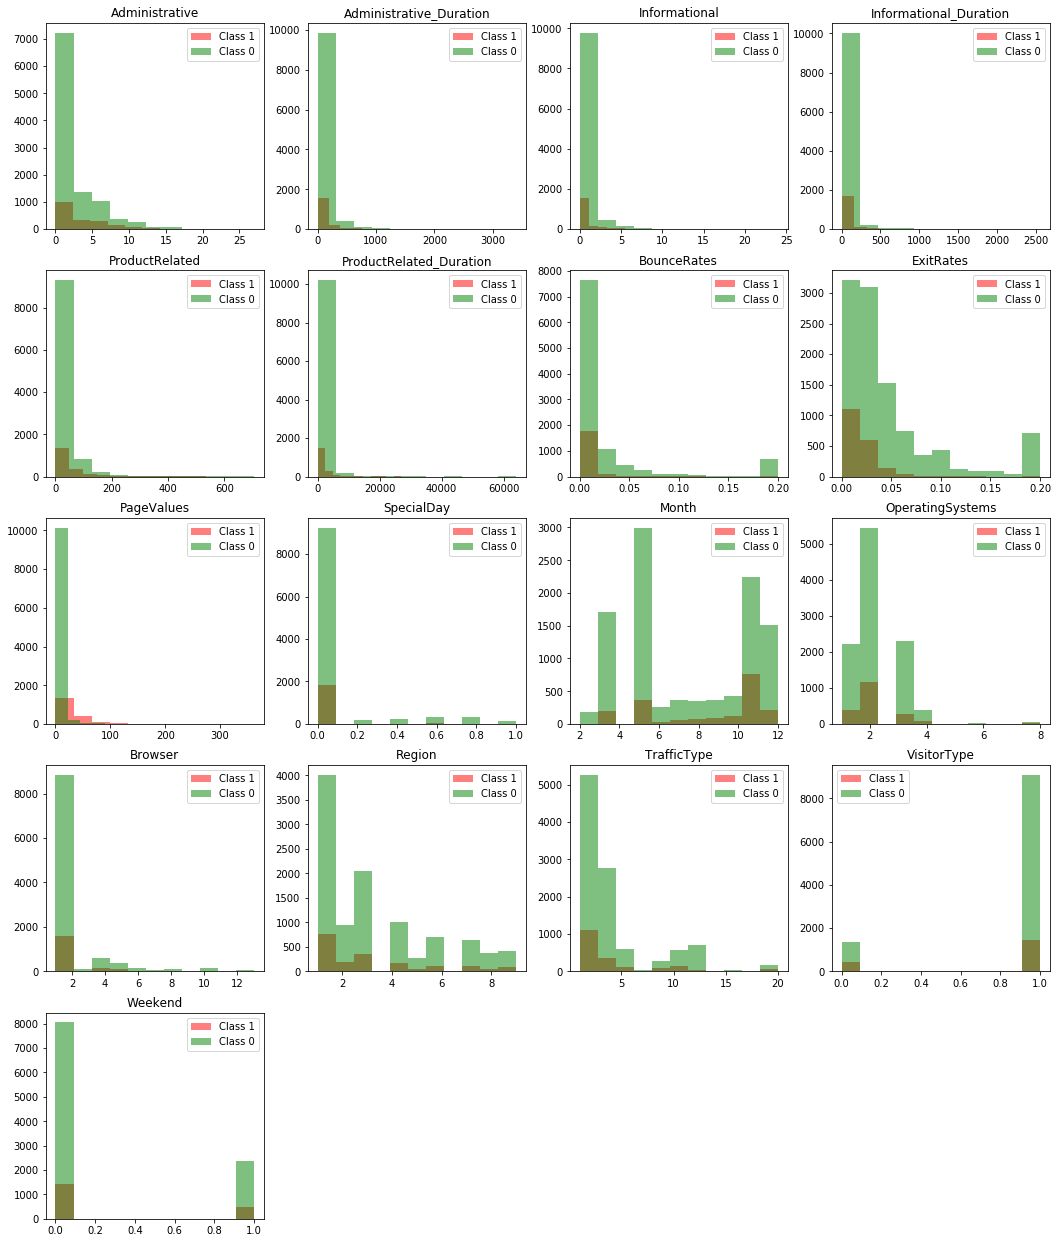

In [28]:
hist_pos_neg_feat(X,Y)

* __Observations of the two variable analysis and some recommendations__:
1. The variables __BounceRates, ExitRates, and PageValues__ have separate distributions when compared to revenue, which might indicate that they are easier to discriminate.

=> The higher the value of the __PageValue__, the greater the probability that income will be generated

=> For both __BounceRates and ExitRates__ the lower the value, the higher the probability that revenue will be generated.

2. __SpecialDay__: Most of the income does not come from dates close to special events. This makes sense since in the dataset the visitor sessions were analyzed for a whole year and from 365 days the dates are reduced due to festivities. But those revenues that came related to a special day, were mostly days close to the holiday (value 0.6)
3. __Product & ProductRelated__ The number of web pages and the duration on the website related to the product, seems to be a good indicator for income
4. __Month__: We see high customer engagement during the months of March and May after which the trend seems to slow down. Between the months of June and October the trend appears to plateau, after which there appears to be high engagement in the month of November. Season sales could be used more if seasonal promotions were introduced with attractive offers and events that attract more purchases.
5. The sites with the most income tend to be those with the highest __PageValues__, which makes sense since this value is calculated with the intention of knowing which page has contributed the most to the website's income.
6. __Weekend__: Most visitors shopped on weekdays. It could be used even more if it were to attract more customers to see and buy during the weekends.
7. __Region__ 1 and 2 show significantly more income than the other regions. This is a good indicator to change strategy in lower regions and adapt a model-based approach similar to Region 1, perhaps personalizing ads based on social and cultural factors through A/B testing.
8. __Browser__ 1 produces much more revenue than other browsers. It would be interesting to know which browsers are included in the study. This could represent an opportunity to improve the website for the other browsers (maybe fonts are niche, not user-friendly or smartphone-friendly). Either way it would be important for the company to ensure smooth technical operation with an improved and personalized user interface experience, compatible with all browsers and operating systems.

### IV. Pearson correlation matrix:

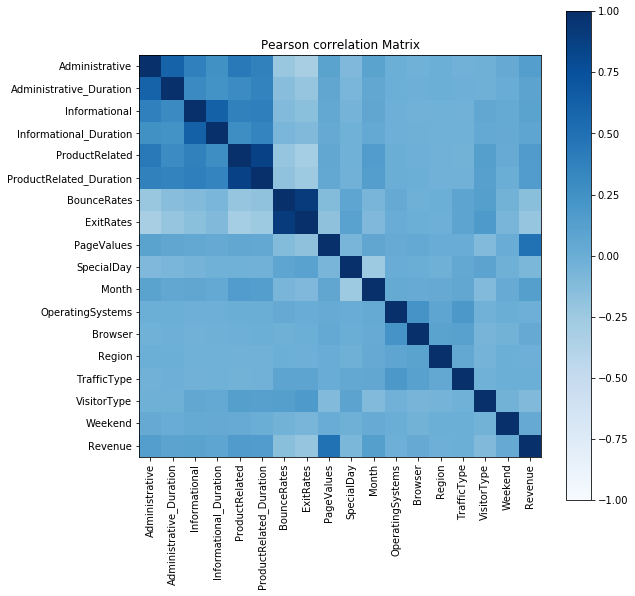

In [29]:
corr_matrix = XY.corr(method='pearson')
n_ticks = len(XY.columns)

plt.figure( figsize=(9, 9) )
plt.xticks(range(n_ticks), XY.columns, rotation='vertical')
plt.yticks(range(n_ticks), XY.columns)
plt.colorbar(plt.imshow(corr_matrix, interpolation='nearest', 
                            vmin=-1., vmax=1., 
                            cmap=plt.get_cmap('Blues')))
_ = plt.title('Pearson correlation Matrix')

* **Variables ordered by their correlation with the target variable:**

In [30]:
corr_target = corr_matrix.values[ -1, : -1]
inverse_index =  abs(corr_target[ : ]).argsort()[ : : -1]
dictionary = {}
for name, correlation in zip( X.columns[inverse_index], list(corr_target[inverse_index] ) ):
    dictionary[name] = correlation

matrix = (pd.DataFrame.from_dict(dictionary, orient='index', columns=['Correlation with the target'])
).sort_values('Correlation with the target', ascending=False)

matrix.style.apply(highlight_max)

,Correlation with the target
PageValues,0.492569
ProductRelated,0.158538
ProductRelated_Duration,0.152373
Administrative,0.138917
Month,0.127372
Informational,0.095200
Administrative_Duration,0.093587
Informational_Duration,0.070345
Weekend,0.029295
Browser,0.023984


* **Correlation results:**

As seen before, the variables that can be more predictive for the target are: __PageValue, ExitRates, ProductRelated, BounceRates, Administrative and Month__

The __PageValue, ProductRelated, Administrative, and Month__ variables. They have a high correlation (49.24%, 15.82%, 13.86% and 12.68% respectively) with the target variable.

On the other hand, the variables __ExitRates, BounceRates, VisitorType and SpecialDay__ show a high negative correlation (20.68%, 15.06%, 10.36% and 8.24% respectively) with the target variable.

In the Heatmap it was also possible to observe that there are apparently strong correlations between the independent variables, which is not a good indicator if we are going to carry out the model. For this reason, we will take a look at _multicollinearity_ between the independent variables later.

## Data processing (II) - Distribution of continuous variables and treatment of outliers

### I. Transformation of data to fulfill the hypotheses:

Before creating ML models, it is always good to verify that they comply with a normal distribution and depending on the type of model to be used, you must choose whether or not to treat the outliers.

Before standardizing a variable, it is convenient to make sure of its distribution, being aware of whether the variable in question comes from a normal distribution or not, for this statistical tests are used, in this case, we will use the **shapiro normality test**, available also in the scipy library.

* The Shapiro normality test suggests the following based on the p-value obtained, as always, taking into account a threshold of 0.05.

> p-value <= 0.05: We reject null hypothesis H0, the sample does not come from a normal distribution, we take alternative hypothesis H1.

> p-value > 0.05: We do not reject the null hypothesis, therefore, we assume that the sample comes from a normal distribution

The test returns two values, the statistical value of the test and the p-value, we will focus on the use of the p-value to check the normality of the variables.

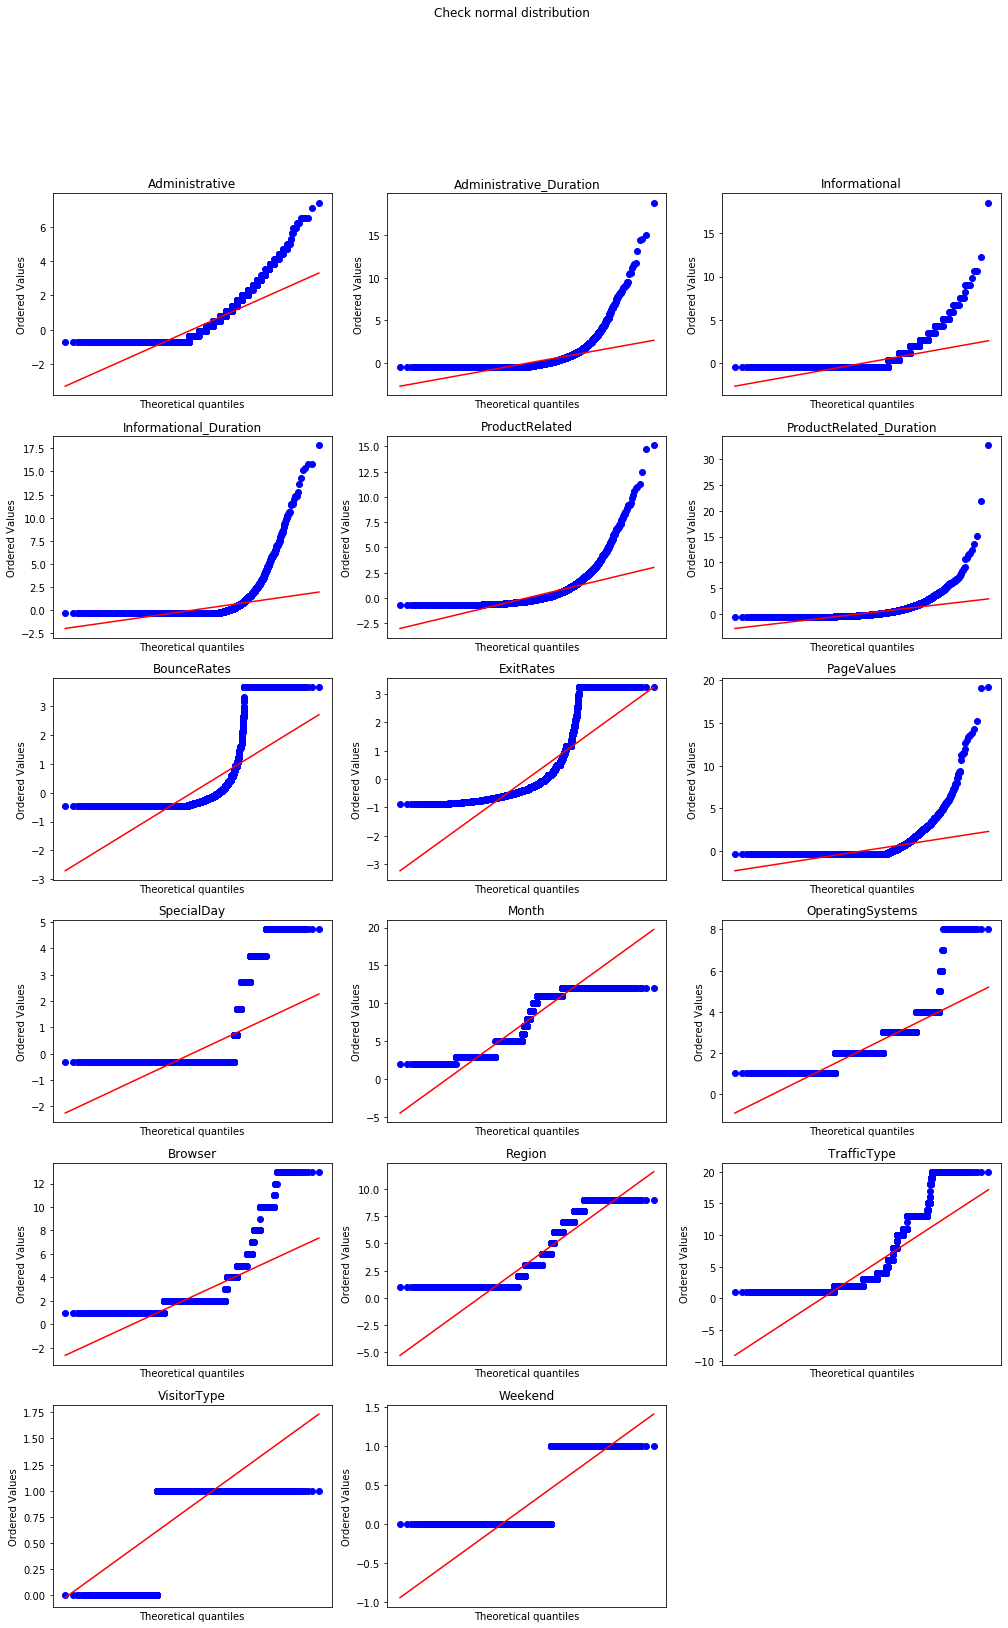

In [31]:
shapiro_test = shapiro_test_normality(X_scaler, title='Check normal distribution')

In [32]:
for numerical_column in X_scaler:
    '''
    We apply the shapiro test to check the distribution
    of the dataset according to p-value
    ''' 
    stat, p = shapiro(X_scaler[numerical_column])
    print("\033[1m *{}*\033[0m".format(numerical_column), 'Test value=%.3f, p-value=%.3f' % (stat, p), '\n')


 *Administrative* Test value=0.734, p-value=0.000 

 *Administrative_Duration* Test value=0.482, p-value=0.000 

 *Informational* Test value=0.458, p-value=0.000 

 *Informational_Duration* Test value=0.260, p-value=0.000 

 *ProductRelated* Test value=0.610, p-value=0.000 

 *ProductRelated_Duration* Test value=0.555, p-value=0.000 

 *BounceRates* Test value=0.492, p-value=0.000 

 *ExitRates* Test value=0.699, p-value=0.000 

 *PageValues* Test value=0.355, p-value=0.000 

 *SpecialDay* Test value=0.343, p-value=0.000 

 *Month* Test value=0.850, p-value=0.000 

 *OperatingSystems* Test value=0.758, p-value=0.000 

 *Browser* Test value=0.567, p-value=0.000 

 *Region* Test value=0.825, p-value=0.000 

 *TrafficType* Test value=0.710, p-value=0.000 

 *VisitorType* Test value=0.418, p-value=0.000 

 *Weekend* Test value=0.523, p-value=0.000 



* As we can observe, none of the categorical variables comes from a normal distribution (p-value is always less than 0.05). For this reason it is essential to standardize the variables of the dataset, this will be done in the section **Data processing (IV)**

### II. Treatment of outliers:

Since we are going to apply the following algorithms: __Logistic Regression, Support Vector Machine and Random Forest Classifier__, the data must meet a series of hypotheses.

Since these algorithms are very prone to outliers, we must transform the variables to follow a normal distribution and deal with outliers.

There are different methods to deal with extreme values. In this case, the interquartile range (IQR) method will be used due to its simplicity, where we will replace the extreme values with quartiles 1 and 3.

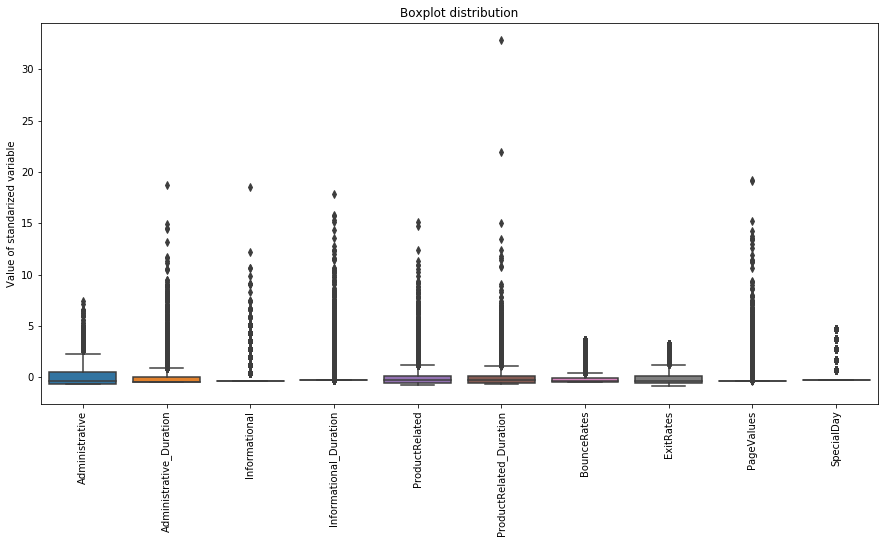

In [33]:
# Visualizing outliers

plt.figure(figsize=(15,7))
ax = sns.boxplot(data=X_scaler[num_features])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title(u'Boxplot distribution')
plt.ylabel('Value of standarized variable')
plt.show()

__NOTE:__

* We will change the upper bound quartile 0.95 to only replace the extreme values without losing as much information:

In [34]:
# Creating a variable to deal with outliers greater than the 0.95 quartile

X_scaler_Q95 = X_scaler.copy()

for k in list(X_scaler_Q95.columns):
    ''' 
    Replace max values to value of quartil 0,95
    ''' 
    IQR = np.percentile(X_scaler_Q95[k],95) - np.percentile(X_scaler_Q95[k],25)
    
    upper_outer_fence = np.percentile((IQR * 3) + X_scaler_Q95[k],95)  
    #lower_outer_fence = np.percentile((IQR * 3) - X_scaler_Q95[k],25) <- not needed, since we only treat the upper bound
    
    X_scaler_Q95[k] = np.where(X_scaler_Q95[k] > upper_outer_fence, upper_outer_fence, X_scaler_Q95[k]) 
    #X_scaler_Q95[k] = np.where(X_scaler_Q95[k] < lower_outer_fence, lower_outer_fence, X_scaler_Q95[k]) <- not needed, since we only treat the upper bound

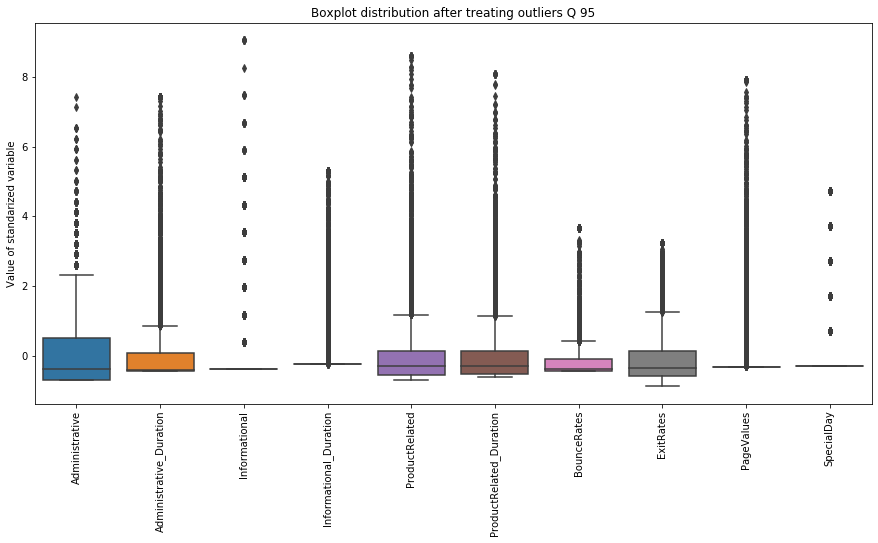

In [35]:
plt.figure(figsize=(15,7))
ax = sns.boxplot(data=X_scaler_Q95[num_features])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title(u'Boxplot distribution after treating outliers Q 95')
plt.ylabel('Value of standarized variable')
plt.show()

## Data processing (III) - Multicollinearity analysis and dummy variables

### I. Detecting multicollinearity

Multicollinearity exists if there are two or more independent variables in a dataset that have a very high correlation with each other.

One of the most common methods to detect multicollinearity is the VIF - Variance Inflation Factor.

__How to interpret VIF values?__

The VIF value starts at 1 and has no upper limit. A general rule of thumb for interpreting VIFs is as follows:

* A value of 1 indicates that there is no correlation between a given explanatory variable and any other explanatory variable in the model.
* A value between 1 and 5 indicates a moderate correlation between a given explanatory variable and other explanatory variables in the model, but often not severe enough to warrant attention.
* A value greater than 5 indicates a potentially severe correlation between a given explanatory variable and other explanatory variables in the model. In this case, the estimates of the coefficients and p-values from the regression output are likely to be unreliable.

In [36]:
# Dataset without treatment of outliers:

vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X_scaler.values, i) for i in range(X_scaler.shape[1])]
vif['variable'] = X_scaler.columns

# Dataset with treatment of outliers quartile 95:
vif_q95 = pd.DataFrame()
vif_q95['VIF'] = [variance_inflation_factor(X_scaler_Q95.values, i) for i in range(X_scaler_Q95.shape[1])]
vif_q95['variable'] = X_scaler_Q95.columns

df_vif = pd.concat([vif,vif_q95],axis=1,keys=['vif','vif_Q95'])
df_vif

vif                            vif_Q95                         
         VIF                 variable       VIF                 variable
0   1.944085           Administrative  2.040168           Administrative
1   1.691065  Administrative_Duration  1.718501  Administrative_Duration
2   1.832233            Informational  2.083836            Informational
3   1.678396   Informational_Duration  1.907019   Informational_Duration
4   4.423192           ProductRelated  4.759533           ProductRelated
5   4.329261  ProductRelated_Duration  4.576408  ProductRelated_Duration
6   6.393581              BounceRates  6.404108              BounceRates
7   7.080948                ExitRates  7.116448                ExitRates
8   1.054960               PageValues  1.060752               PageValues
9   1.086738               SpecialDay  1.087693               SpecialDay
10  4.949271                    Month  4.999443                    Month
11  5.890861         OperatingSystems  6.309196         OperatingSystems
12  2.989374                  Browser  2.938684                  Browser
13  2.619000                   Region  2.617098                   Region
14  2.128033              TrafficType  2.116951              TrafficType
15  4.663207              VisitorType  4.855669              VisitorType
16  1.290095                  Weekend  1.291625                  Weekend

__NOTE:__

* The variables **ExitRates and BounceRates** yield in both datasets (with outliers and without outliers) a value greater than 6, which indicates multicollinearity and therefore a strong relationship between the two (see the scatter plot below). Since this value is not acceptable, one of the two variables must be eliminated before creating the model. We will remove the variable __ExitRates__

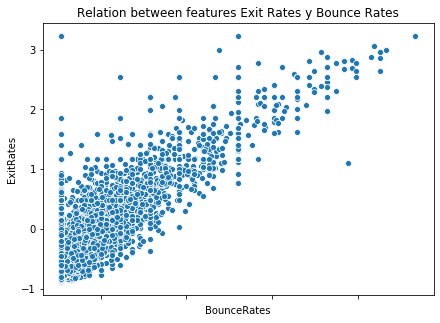

In [37]:
plt.figure(figsize=(7,5))
ax = sns.scatterplot(data=X_scaler_Q95, x="BounceRates", y='ExitRates')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title(u'Relation between features Exit Rates y Bounce Rates')
plt.show()

In [38]:
print("Before changes: ",X_scaler_Q95.shape[1], "columns")

X_scaler_Q95 = X_scaler_Q95.drop(columns=['ExitRates'], axis=1)

print("After changes: ",X_scaler_Q95.shape[1], "columns")

Before changes:  17 columns
After changes:  16 columns


### II. Creation of dummy variables (2nd transformation of categorical variables)

* As we know from previous steps, the original categorical variables are represented now by numbers. But these sequence of numbers don't have any ranking. Machine learning algorithms treat the order of numbers as an attribute of significance. In other words, they will read a higher number as better or more important than a lower number.

* **One hot encoding** is useful for data that has no relationship to each other. The dummy variables are generated in a binary way taking values 0 or 1 and generating a new column for each label or category. We will use the one hot encoding techniques offered in pandas library *called get_dummies*

In [39]:
cat_features_X = (XY[cat_features].columns).drop('Revenue')

df_cat = X_scaler_Q95[cat_features_X].copy() 
df_cat = pd.get_dummies(df_cat, columns=cat_features_X)
df_cat[:2]

,Month_2.0,Month_3.0,Month_5.0,Month_6.0,Month_7.0,Month_8.0,Month_9.0,Month_10.0,Month_11.0,Month_12.0,OperatingSystems_1.0,OperatingSystems_2.0,OperatingSystems_3.0,OperatingSystems_4.0,OperatingSystems_5.0,OperatingSystems_6.0,Browser_1.0,Browser_2.0,Browser_3.0,Browser_4.0,Browser_5.0,Browser_6.0,Browser_7.0,Browser_8.0,Browser_9.0,Browser_10.0,Browser_11.0,Browser_12.0,Browser_13.0,Region_1.0,Region_2.0,Region_3.0,Region_4.0,Region_5.0,Region_6.0,Region_7.0,Region_8.0,Region_9.0,TrafficType_1.0,TrafficType_2.0,TrafficType_3.0,TrafficType_4.0,TrafficType_5.0,TrafficType_6.0,TrafficType_7.0,TrafficType_8.0,TrafficType_9.0,TrafficType_10.0,TrafficType_11.0,TrafficType_12.0,TrafficType_13.0,TrafficType_14.0,TrafficType_15.0,TrafficType_16.0,TrafficType_17.0,TrafficType_18.0,TrafficType_19.0,TrafficType_20.0,VisitorType_0.0,VisitorType_1.0,Weekend_0.0,Weekend_1.0
0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0


* As we can see above, the old categorical columns were eliminated and a new column was generated for each label or category

## Data processing (IV) - Spliting and standarizing the dataset

In this step:

* We will scale both X_train and X_test using  <code> __StandardScaler__</code> for the numerical columns. Standarization should be always done after splitting the data between training and test set, applying it first to the X training set and then on the X test set.

* A thumb rule to split the modelling dataset into training and testing sets is to assign 2/3 data points to the former and the remaining one-third to the latter. Therefore, I have used 0.7 for the train size.

### II. Unifying dataset

In [40]:
# Replacing max values to value of quartil 0,95
# for values not yet standarized
df_num = X.copy()
df_num = df_num[num_features]

for k in list(df_num[num_features].columns):
    IQR = np.percentile(df_num[k],95) - np.percentile(df_num[k],25)
    upper_outer_fence = np.percentile((IQR * 3) + df_num[k],95)
    df_num[k] = np.where(df_num[k] > upper_outer_fence, upper_outer_fence, df_num[k])

In [41]:
# Unifying both df numerical and categorical df

X_modif = pd.concat([df_num, df_cat], axis=1)
X_modif = X_modif.drop(['ExitRates'], axis=1)
X_modif[:3]

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,PageValues,SpecialDay,Month_2.0,Month_3.0,Month_5.0,Month_6.0,Month_7.0,Month_8.0,Month_9.0,Month_10.0,Month_11.0,Month_12.0,OperatingSystems_1.0,OperatingSystems_2.0,OperatingSystems_3.0,OperatingSystems_4.0,OperatingSystems_5.0,OperatingSystems_6.0,Browser_1.0,Browser_2.0,Browser_3.0,Browser_4.0,Browser_5.0,Browser_6.0,Browser_7.0,Browser_8.0,Browser_9.0,Browser_10.0,Browser_11.0,Browser_12.0,Browser_13.0,Region_1.0,Region_2.0,Region_3.0,Region_4.0,Region_5.0,Region_6.0,Region_7.0,Region_8.0,Region_9.0,TrafficType_1.0,TrafficType_2.0,TrafficType_3.0,TrafficType_4.0,TrafficType_5.0,TrafficType_6.0,TrafficType_7.0,TrafficType_8.0,TrafficType_9.0,TrafficType_10.0,TrafficType_11.0,TrafficType_12.0,TrafficType_13.0,TrafficType_14.0,TrafficType_15.0,TrafficType_16.0,TrafficType_17.0,TrafficType_18.0,TrafficType_19.0,TrafficType_20.0,VisitorType_0.0,VisitorType_1.0,Weekend_0.0,Weekend_1.0
0,0.0,0.0,0.0,0.0,1.0,0.0,0.2,0.0,0.0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
1,0.0,0.0,0.0,0.0,2.0,64.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.2,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0


### II. Splitting training set and test set

In [42]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_modif, Y, train_size=0.7, random_state=4)

### III. Standarizing X and Y train

In [43]:
# Standardizing the numerical columns
# a. Selecting only variables with numerical features of X_train and X_test set (y remains untouchable)
nr_features = ['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'PageValues', 'SpecialDay']

features_train = X_train[nr_features]
features_test = X_test[nr_features]

# b. Applying scaler: fit & fit_transform to X_train and transform to X_test
scaler = StandardScaler().fit(features_train.values)
features_train = scaler.fit_transform(features_train.values)
features_test = scaler.transform(features_test.values)

# c. Updating X_train and X_test with normalized numerical values
X_train[nr_features] = features_train
X_test[nr_features] = features_test

# Model Building

In this section we will create the models. We will apply three classification algorithms, which we will optimize with <code>__CrossValidation__</code> and <code> __GridSearch__</code>:

__1. Logistic Regression (basic simple algorithm)__

__2. Support Vector Machine Classification- SVC (adding a hyperplane)__

__3. Random Forest Classification (bagging algorithm)__

* Later we will check which of all these algorithms performs better. Since the target class is unbalanced, we will use the AUC as a performance metric to compare the different classifiers.

### I. Feature Reduction:

* As shown below, after aplying the One-Hot Encoder to transform the categorical variables, we obtained 71 columns. These columns may not be all relevant to the future model and reducing the dataset, would decrease latencies in the algorithm computations. We will have look at this by using the Feature Importance.
* This technique calculate a score for all the input features for a given model — the scores simply represent the “importance” of each feature.

In [44]:
print('Nr. of columns in the dataset: ',X_modif.shape[1])

Nr. of columns in the dataset:  71


- Once the model is created and "fitted", we can conduct feature importance and show the results in a df to interpret the results easily:

In [45]:
# Choosing a base algorithm to apply the importance feature
rf = RandomForestClassifier(random_state=4)

# Fitting the model
rf.fit(X_train, y_train)

# Applying the feature importance function to the rf model
sort = rf.feature_importances_.argsort()

In [46]:
pd.set_option('display.max_rows', None)

# Creating a DataFrame with the results obtained
feature_importance = pd.DataFrame({'Features':X_modif.columns[sort], 'Importance Score':rf.feature_importances_[sort]})
feature_importance = feature_importance.sort_values(by='Importance Score', ascending=False).reset_index(drop=True)

# Taking only columns with score > 0.005
#feature_importance
feature_importance = feature_importance.head(30)
feature_importance

,Features,Importance Score
0,PageValues,0.332088
1,ProductRelated_Duration,0.091660
2,ProductRelated,0.076474
3,Administrative_Duration,0.061894
4,BounceRates,0.060392
5,Administrative,0.046609
6,Informational_Duration,0.030463
7,Informational,0.021922
8,Month_11.0,0.021694
9,Region_1.0,0.013024


In [47]:
final_features = feature_importance['Features'].tolist()

X_modif = X_modif[X_modif.columns.intersection(final_features)]

In [48]:
print('New nr. of columns in the dataset: ',X_modif.shape[1])

New nr. of columns in the dataset:  30


### II. Splitting training set and test set after features reduction

In [49]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_modif, Y, train_size=0.7, random_state=4)

### III. Standarizing X and Y train

In [50]:
# Standardizing the numerical columns
# a. Selecting only variables with numerical features of X_train and X_test set (y remains untouchable)
nr_features = ['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'PageValues']

features_train = X_train[nr_features]
features_test = X_test[nr_features]

# b. Applying scaler: fit & fit_transform to X_train and transform to X_test
scaler = StandardScaler().fit(features_train.values)
features_train = scaler.fit_transform(features_train.values)
features_test = scaler.transform(features_test.values)

# c. Updating X_train and X_test with normalized numerical values
X_train[nr_features] = features_train
X_test[nr_features] = features_test

### III. Defining the functions needed to optimize the models

* __Definición de la función "training_model_hyperparamter__:

For the training of the models, we will optimize the parameters of each classification model using the following two functions:

1. <code>__StratifiedKFold__</code> variation of KFold that returns stratified folds. The folds are performed keeping the percentage of samples for each class, which is convenient in this case since the dataset is not equally divided into its classes.
2. <code>__GridSearchCV__</code> exhaustive search on the values of the specified parameters for an estimator

In [51]:
def training_model_hyperparameter(model, scoring, params_grid, X_train, y_train):
    folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state=100) 

    grid = GridSearchCV(estimator = model, scoring=scoring, param_grid = params_grid, cv = folds, 
                           verbose=10, return_train_score=True, n_jobs=-1)
    grid.fit(X_train, y_train)
    return grid

def prediction_model(model, X_train, y_train, X_test, y_test):
    '''
    Evaluate the performance of each model using the AUC as metric. 
    We will predict values and probabilities for the training and testing set.
    '''
    y_train_pred = model.predict(X_train)
    y_train_pred_prob = model.predict_proba(X_train)[:, 1]
    y_test_pred = model.predict(X_test)
    y_test_pred_prob = model.predict_proba(X_test)[:, 1]
    return y_train_pred, y_train_pred_prob, y_test_pred, y_test_pred_prob


def draw_roc(train_actual, train_probs, test_actual, test_probs):
    '''
    Draw ROC curve from training and test data probability
    to compare the models
    '''
    train_fpr, train_tpr, train_thresholds = metrics.roc_curve( train_actual, train_probs,
                                              drop_intermediate = False )
    test_fpr, test_tpr, test_thresholds = metrics.roc_curve( test_actual, test_probs,
                                              drop_intermediate = False )
    train_auc_score = metrics.roc_auc_score( train_actual, train_probs )
    test_auc_score = metrics.roc_auc_score( test_actual, test_probs )
    plt.figure(figsize=(5, 5))
    plt.plot( train_fpr, train_tpr, label='ROC curve train (area = %0.2f)' % train_auc_score )
    plt.plot( test_fpr, test_tpr, label='ROC curve test (area = %0.2f)' % test_auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    return None

### IV. Applying ML Algorithms

## __a. Logistic Regression__

In [52]:
lr = LogisticRegression()

# We create the param_grid dictionary with the values to optimize
lr_param_grid = {
    'max_iter': [50, 100],
    'C': [0.01, 0.05, 1],
    'solver': ['liblinear', 'lbfgs']
}

In [53]:
lr_grid = training_model_hyperparameter(model=lr, scoring='roc_auc', params_grid=lr_param_grid, X_train=X_train, y_train=y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [54]:
y_train_pred_lr, y_train_pred_lr_prob, y_test_pred_lr, y_test_pred_lr_prob = prediction_model(
    lr_grid, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

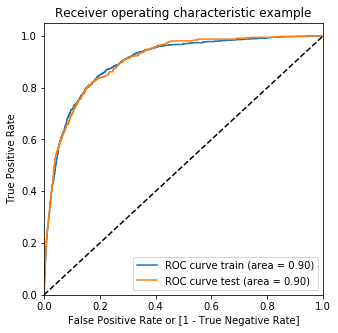

In [55]:
draw_roc(train_actual=y_train, train_probs=y_train_pred_lr_prob, test_actual=y_test, test_probs=y_test_pred_lr_prob)

In [56]:
lr_grid.best_params_

{'C': 0.01, 'max_iter': 50, 'solver': 'lbfgs'}

* With <code>__GridSearchCV__</code> an optimization is performed. What this function does is adjust the model that is passed as an argument with all the possible combinations of the parameters. In this case, all combinations of __C, max_iter and solver__

## __b. Support Vector Machine Classifier__

In [57]:
# Train Gradient Boosting Classifier model with hyperparameter tuning
svc_model = SVC(probability=True)
params_grid_svc = {
    "kernel": ["rbf", "poly"],
    "degree": [1, 2, 3], 
}

In [58]:
svc_grid = training_model_hyperparameter(model=svc_model, scoring='roc_auc', params_grid=params_grid_svc, X_train=X_train, y_train=y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


In [59]:
y_train_pred_svc, y_train_pred_svc_prob, y_test_pred_svc, y_test_pred_svc_prob = \
                                    prediction_model(svc_grid, X_train, y_train, X_test, y_test)

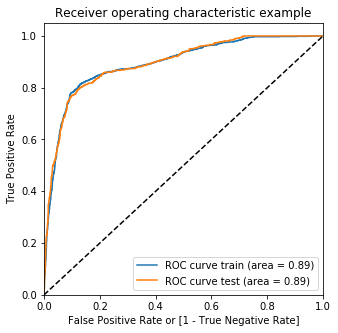

In [60]:
draw_roc(y_train, y_train_pred_svc_prob, y_test, y_test_pred_svc_prob)

In [61]:
svc_grid.best_params_

{'degree': 1, 'kernel': 'poly'}

## __c. Random Forest Classifier__

In [62]:
rf_model = RandomForestClassifier(random_state=4)

params_grid_rf = {'n_estimators': [50,100,400,600,1000,1200,1500],
              'max_features': ['auto', 'sqrt'],
              'bootstrap' : [True, False]
                 }

In [63]:
rf_grid = training_model_hyperparameter(model=rf_model, scoring='roc_auc', params_grid=params_grid_rf, X_train=X_train, y_train=y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


In [64]:
y_train_pred_rf, y_train_pred_rf_prob, y_test_pred_rf, y_test_pred_rf_prob = \
                                    prediction_model(rf_grid, X_train, y_train, X_test, y_test)

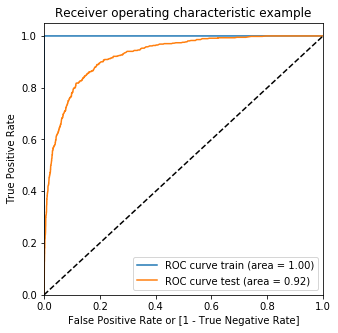

In [65]:
draw_roc(y_train, y_train_pred_rf_prob, y_test, y_test_pred_rf_prob)

In [66]:
rf_grid.best_params_

{'bootstrap': True, 'max_features': 'auto', 'n_estimators': 1500}

### V. Comparing models

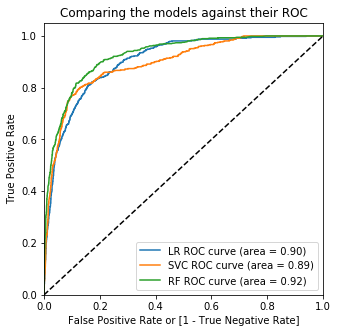

In [67]:
lr_fpr, lr_tpr, lr_thresholds = metrics.roc_curve( y_test, y_test_pred_lr_prob, drop_intermediate = False )
svc_fpr, svc_tpr, svc_thresholds = metrics.roc_curve( y_test, y_test_pred_svc_prob, drop_intermediate = False )
rf_fpr, rf_tpr, rf_thresholds = metrics.roc_curve( y_test, y_test_pred_rf_prob, drop_intermediate = False )

lr_auc_score = metrics.roc_auc_score( y_test, y_test_pred_lr_prob )
svc_auc_score = metrics.roc_auc_score( y_test, y_test_pred_svc_prob )
rf_auc_score = metrics.roc_auc_score( y_test, y_test_pred_rf_prob )

plt.figure(figsize=(5, 5))
plt.plot( lr_fpr, lr_tpr, label='LR ROC curve (area = %0.2f)' % lr_auc_score )
plt.plot( svc_fpr, svc_tpr, label='SVC ROC curve (area = %0.2f)' % svc_auc_score )
plt.plot( rf_fpr, rf_tpr, label='RF ROC curve (area = %0.2f)' % rf_auc_score )
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
plt.ylabel('True Positive Rate')
plt.title('Comparing the models against their ROC')
plt.legend(loc="lower right")
plt.show()

__Conclusions__:

* Note: An ROC curve (receiver operating characteristic curve) is a graph showing the performance of a classification model at all classification thresholds. This curve plots two parameters: True Positive Rate. False Positive Rate.

* As observed in the ROC curve graph, the Logistic Regression and the Random Forest are performing better than the Support Vector Classifier. Moreover, the Random Forest model offers better results (area=1 in the train set and area=0.92 in the test set)

## __Analysis of the chosen model: Random Forest__

In [68]:
# Analyzing the predictions
y_test_pred_prob_rf_pos = y_test_pred_rf_prob[np.where(y_test == 1)[0]]
y_test_pred_prob_rf_neg = y_test_pred_rf_prob[np.where(y_test == 0)[0]]

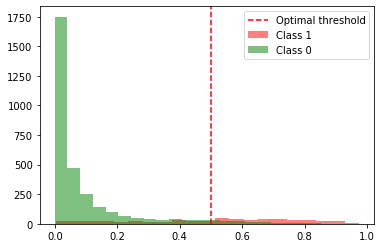

In [69]:
double_hist(y_test_pred_prob_rf_pos, y_test_pred_prob_rf_neg, n_bins=21, density=0)
plt.axvline(x=0.5, color='red', linestyle='--', label='Optimal threshold')
plt.legend()
plt.show()

* We have used __0.6__ as the threshold or cut-off point since class 0 is concentrated approximately from 0.0 to 0.6. After this point almost all values blong to Class 1

In [70]:
threshold = 0.5
y_threshold = 1*(y_test_pred_rf_prob > threshold)

In [71]:
def graph_matrix_confusion(matrix):
    '''
    Designing the matrix graph
    '''
    df_matrix_confusion = pd.DataFrame(matrix,
                     ['True No Revenue','True Revenue'],
                     ['Pred No Revenue','Pred Revenue'])
    plt.figure(figsize = (8,4))
    sns.set(font_scale=1.4)
    plt.title(u'Confusion matrix')
    _ = sns.heatmap(df_matrix_confusion, annot=True, annot_kws={"size": 16}, fmt='g')
    
def reporting_model(y_true, y_pred):
    '''
    Adding the metrics infos of the model
    '''
    matrix_confusion = metrics.confusion_matrix(y_true, y_pred)
    roc_auc = metrics.roc_auc_score(y_true, y_pred)
    metric_f1 = metrics.f1_score(y_true, y_pred)
    print(u'ROC-AUC: {}'.format(round(roc_auc,2)))
    print(u'F1-score: {}'.format(round(metric_f1,2)))
    print("\nAccuracy\t{}".format(round(metrics.accuracy_score(y_true, y_pred),3)))  
    print("Sensitivity/Recall\t{}".format(round(metrics.recall_score(y_true, y_pred),3)))
    print(u"Precision\t{}".format(round(metrics.precision_score(y_true, y_pred),3)))   
    graph_matrix_confusion(matrix_confusion)

ROC-AUC: 0.77
F1-score: 0.65

Accuracy	0.903
Sensitivity/Recall	0.58
Precision	0.736


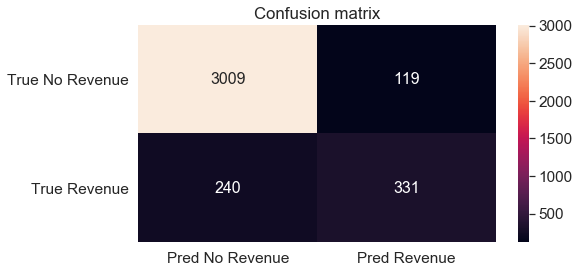

In [72]:
reporting_model(y_test, y_threshold)

__FINAL CONCLUSION:__

* The objective of this business case is to perform a series of specific actions for customers who are more likely to make purchases on the web.

* Our model has an accuracy of 90% and a precision of 75% but a recall of 52%.

* Overall the model is performing as following:

>__True Positive__: 3.047 customers who we predicted would make purchases on the web where revenue was actually earned.

>__False Negative__: 261 customers of whom we have predicted that they would make purchases on the web but they did not (Type II error).

>__False Positive__: 98 clients of whom we have predicted that they would not make purchases on the web but they did (Type I error)

>__True Negative__: 289 customers who we predicted would not make purchases on the web where no revenue was actually earned.

* The recall is a 52% (we are not predicting 261 cases as revenue). Considering the problem for this business case, we could modify the threshold as shown below to increase the recall and have higher predicted revenues. However, increasing the recall would mean decreasing the precision. 

* Increasing the true predicted revenues would cause to predict higher mistakes of actual no revenues that where classified as revenue. Depending on the further actions that the retail company will be taken with this model, for example the amount of money spend for promotions/incentives for the potential "revenue" clients, we could spend at the end more money with this wrong predicted revenue clients.


In [73]:
# hypothetical case if we would increase the recall

threshold_2 = 0.30
y_threshold_2 = 1*(y_test_pred_rf_prob > threshold_2)

ROC-AUC: 0.83
F1-score: 0.67

Accuracy	0.886
Sensitivity/Recall	0.757
Precision	0.606


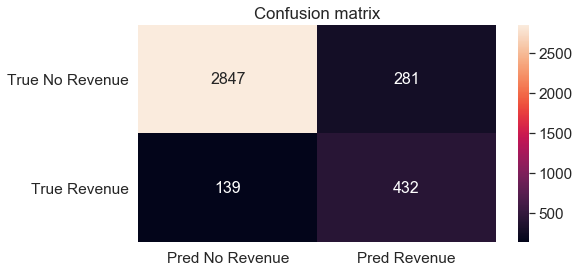

In [74]:
reporting_model(y_test, y_threshold_2)